<a href="https://colab.research.google.com/github/buupq/torch/blob/main/tinyVGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test modules
* download data
* create tinyVGG model
* do training and testing

In [1]:
import torch
import torchvision
from torch import nn
from torchvision import transforms

print(f"torch: {torch.__version__} | torchvision: {torchvision.__version__}")

torch: 2.0.1+cu118 | torchvision: 0.15.2+cu118


In [2]:
# import model sumary
try:
    from torchinfo import sumary
except:
    print(f"[INFO] installing torchinfo...")
    !pip install torchinfo
    from torchinfo import summary

[INFO] installing torchinfo...


In [3]:
# import our source modules
from sources import utils, datasetup, engine, models

2023-11-07 14:25:52.392210: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-07 14:25:52.435164: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-07 14:25:53.141981: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# download data
source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
image_path = datasetup.download_data(source=source)
image_path

[INFO] creating data/images...
[INFO] downloading pizza_steak_sushi.zip to data...
[INFO] extracting pizza_steak_sushi.zip to data/images...
[INFO] removing pizza_steak_sushi.zip...


PosixPath('data/images')

In [6]:
# setup train and test directory
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir.is_dir(), test_dir.is_dir()

(True, True)

In [7]:
# set up a simple composed transforms
#     resize image (64, 64)
#     convert image to torch tensor
#     extra augmented transformation for train dataset

train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5)
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

train_transforms, test_transforms

(Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
     ToTensor()
     RandomHorizontalFlip(p=0.5)
 ),
 Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
     ToTensor()
 ))

In [8]:
# create dataloaders from train, test dirs and simple transforms
train_dataloader, test_dataloader, class_names = datasetup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    batch_size=32
)

[INFO] creating dataloaders... 
train_dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7ff7fce4e450> 
test_dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7ff7fce2e5d0> 
number of class_names: 3


In [9]:
# create model
tinyVGG_0 = models.tinyVGG(
    name="tinyVGG_0",
    inp_shape=3,
    out_shape=len(class_names)
)
tinyVGG_0

[INFO] creating tinyVGG_0 model...


tinyVGG(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [10]:
# check model parameters
summary(
    model=tinyVGG_0,
    input_size=[32, 3, 64, 64],
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20
)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Trainable
tinyVGG                                  [32, 3, 64, 64]      [32, 3]              --                   True
├─Sequential: 1-1                        [32, 3, 64, 64]      [32, 10, 32, 32]     --                   True
│    └─Conv2d: 2-1                       [32, 3, 64, 64]      [32, 10, 64, 64]     280                  True
│    └─ReLU: 2-2                         [32, 10, 64, 64]     [32, 10, 64, 64]     --                   --
│    └─Conv2d: 2-3                       [32, 10, 64, 64]     [32, 10, 64, 64]     910                  True
│    └─ReLU: 2-4                         [32, 10, 64, 64]     [32, 10, 64, 64]     --                   --
│    └─MaxPool2d: 2-5                    [32, 10, 64, 64]     [32, 10, 32, 32]     --                   --
├─Sequential: 1-2                        [32, 10, 32, 32]     [32, 10, 16, 16]     --                   True
│    └─Conv2d: 2-6  

In [11]:
# setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=tinyVGG_0.parameters(), lr=1e-3)

In [12]:
# perform traning
results = engine.train(
    model=tinyVGG_0,
    train_dataloader=train_dataloader,
    test_dataloader = test_dataloader,
    loss_fn = loss_fn,
    optimizer=optimizer,
    epochs=20,
    device=device
)

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 | train_loss: 1.1015 | train_acc: 0.3750 | test_loss: 1.0881 | test_acc: 0.5417
epoch: 1 | train_loss: 1.0938 | train_acc: 0.4023 | test_loss: 1.0784 | test_acc: 0.5417
epoch: 2 | train_loss: 1.1037 | train_acc: 0.2812 | test_loss: 1.0668 | test_acc: 0.5417
epoch: 3 | train_loss: 1.1036 | train_acc: 0.2812 | test_loss: 1.0788 | test_acc: 0.5521
epoch: 4 | train_loss: 1.0874 | train_acc: 0.4727 | test_loss: 1.0739 | test_acc: 0.4839
epoch: 5 | train_loss: 1.0826 | train_acc: 0.3594 | test_loss: 1.0926 | test_acc: 0.3324
epoch: 6 | train_loss: 1.0226 | train_acc: 0.4141 | test_loss: 1.0651 | test_acc: 0.4356
epoch: 7 | train_loss: 1.0023 | train_acc: 0.4336 | test_loss: 0.9476 | test_acc: 0.5843
epoch: 8 | train_loss: 1.0053 | train_acc: 0.4414 | test_loss: 1.0093 | test_acc: 0.4735
epoch: 9 | train_loss: 1.1055 | train_acc: 0.4688 | test_loss: 1.1844 | test_acc: 0.3021
epoch: 10 | train_loss: 0.9199 | train_acc: 0.5664 | test_loss: 1.1528 | test_acc: 0.3816
epoch: 11 | train_lo

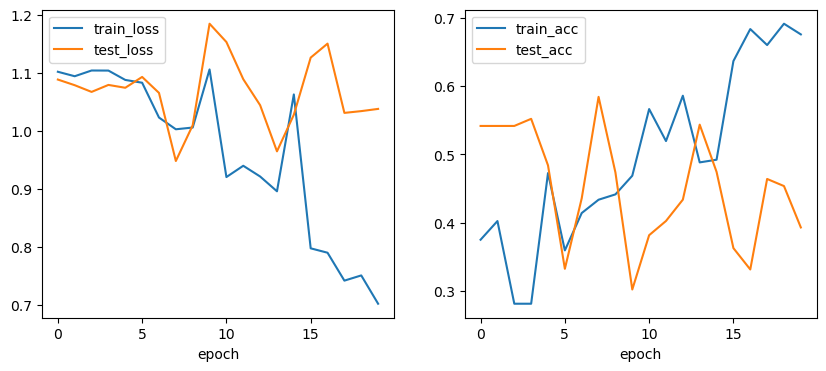

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(results["train_loss"], label="train_loss")
ax[0].plot(results["test_loss"], label="test_loss")
ax[0].set_xlabel("epoch")
ax[0].legend()

ax[1].plot(results["train_acc"], label="train_acc")
ax[1].plot(results["test_acc"], label="test_acc")
ax[1].set_xlabel("epoch")
ax[1].legend()



In [14]:
# save trained model
tinyVGG_0_path = utils.save_model(
    model=tinyVGG_0,
    model_dir="saved_models"
)

# Load saved model

In [15]:
# create model tinyVGG
tinyVGG_1 = models.tinyVGG(
    inp_shape=3,
    out_shape=3,
    hidden_units=10
).to(device)

[INFO] creating tinyVGG model...


In [16]:
# load saved model
utils.load_saved_model(
    loaded_model=tinyVGG_1,
    loaded_path=tinyVGG_0_path
)

tensor([[-2.5603,  2.4014, -2.0852]], device='cuda:0')


'steak'

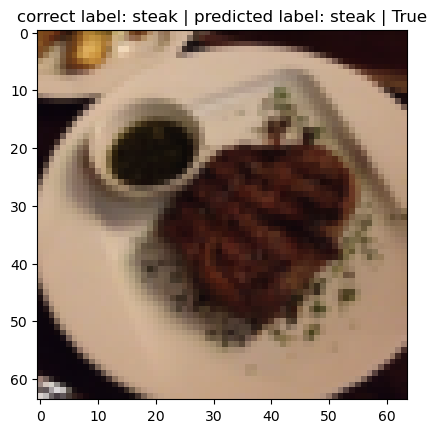

In [17]:
import random
random_path = random.choice(list(image_path.glob("*/*/*")))

utils.predict_label(
    model = tinyVGG_1,
    image_path=random_path,
    class_names=class_names,
    transforms=test_transforms,
    device=device,
    INFO=True
)

tensor([[-2.5603,  2.4014, -2.0852]], device='cuda:0')


'steak'

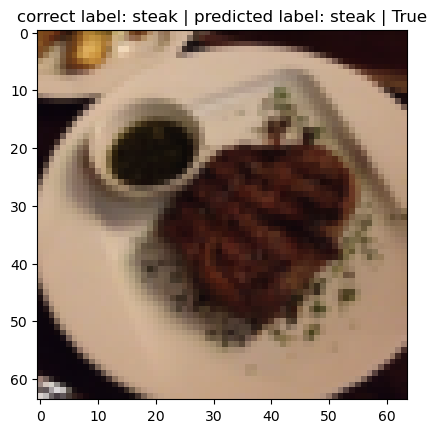

In [18]:
utils.predict_label(
    model = tinyVGG_0,
    image_path=random_path,
    class_names=class_names,
    transforms=test_transforms,
    device=device,
    INFO=True
)